# Mouvement brownien d'une particule colloïdale
## Séance 1

On effectue d'abord les importations necessaires.

In [160]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
%matplotlib inline

In [161]:
File="nico_1.mat"
binning=1
agrandissement=20
PixelSize=binning*(6450/agrandissement)*1e-3 # en um
frequence=400

Ici on précise les constantes comme p.ex. la taille $a$ des billes

In [162]:
a=1 #Taille des billes en µm
temp=293 #Temperature en K
kb=1.38e-11 #Constante de Boltzmann en unités adaptées
file=sio.loadmat(File) #On charge le fichier
Nbobjets = int(max(file['objs_link'][3]))
longueurminimale=int(1e3)
print("On a tracqué "+str(Nbobjets)+" particules")

On a tracqué 21 particules


In [163]:
def take(i):
    """La fonction qui tracque la particule i"""
    x1=file['objs_link'][0,:][np.where(file['objs_link'][5,:]==i)]*PixelSize
    y1 = file['objs_link'][1,:][np.where(file['objs_link'][5,:]==i)]*PixelSize
    dureetrajectoire=x1.shape[0]
    print("Trajectory acquired for particle "+str(i))
    T=np.arange(dureetrajectoire)/frequence
    if dureetrajectoire>0:
        return x1-x1[0],y1-y1[0],T,dureetrajectoire
    else:
        return [0],[0],T,dureetrajectoire

Capture de la trajectoire de la particule i. Ainsi on la capte pour une particule dont la longueur de trajectoire est assez grande (>1000). Et puis on la trace:

Trajectory acquired for particle 0
Trajectory acquired for particle 1


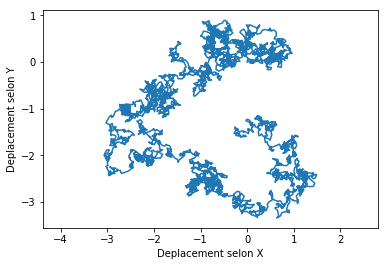

In [164]:
i=0
n=0
while n<1000:
    x,y,t,n=take(i)
    i+=1
plt.plot(x,y)
plt.axis('equal')
plt.xlabel("Deplacement selon X")
plt.ylabel("Deplacement selon Y")
plt.show()

On observe un mouvement qui semble chaotique. Si on regarde juste ou va la particule entre deux moments de temps, voici l'histogramme de la repartitions des deplacements entre deux cadres:

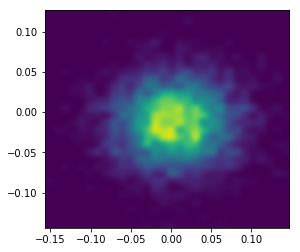

La moyenne se trouve en (-2.15639759036e-05,-0.000391299971304)


In [165]:
dx=x[1:]-x[:-1]
dy=y[1:]-y[:-1]
h, a,b , p = plt.hist2d(dx,dy, 30)
plt.clf()
plt.imshow(h, interpolation = "gaussian",extent=(a[0],a[-1],b[0],b[-1]))
plt.show()
print("La moyenne se trouve en ("+str(dx.mean())+","+str(dy.mean())+")")

On observe quelque chose assez centré, ressemblant a une gaussienne. On va le montrer dans quelques instants.

In [166]:
def autocorr(x,formsd=False):
    fftx = np.fft.fft(x, n=(x.shape[0]*2-1), axis=0)
    cfftx=np.conjugate(fftx)
    ret = np.real(np.fft.ifft(fftx*cfftx, axis=0))
    result = np.fft.fftshift(ret, axes=0)
    result = np.correlate(x, x, mode='full')
    if formsd:
        N=result.size//2+1
        return result[result.size//2:]/(N-np.arange(0,N))
    return result[result.size//2:]

def msd(r):
    N=r.shape[0]
    D=r**2
    D=np.append(D,0)
    S2=autocorr(r,True)
    Q=2*D.sum()
    S1=np.zeros(N)
    for m in range(N):
        Q=Q-D[m-1]-D[N-m]
        S1[m]=Q/(N-m)
    return np.arange(N)/frequence,S1-2*S2

Calcul de l'autocorrelation et du mean square distance. Montrons que le mouvement est en effet chaotique, calculons l'autocorrelation du vecteur deplacement:

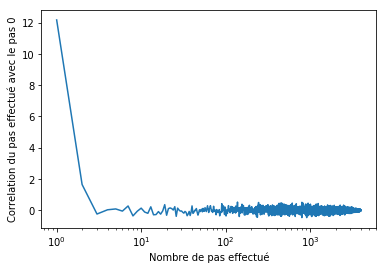

In [167]:
Corr=autocorr(dx)+autocorr(dy)
plt.semilogx(range(1,len(Corr)+1),Corr)
plt.xlabel("Nombre de pas effectué")
plt.ylabel("Correlation du pas effectué avec le pas 0")
plt.show()

Montrons desormais que la repartition est bien gaussienne.

In [168]:
def GaussianHisto(dx,n=30):
    """
    Fonction qui calcule l'histogramme supposé gaussien et le fite
    """
    a,b=np.histogram(dx,n)
    x,y=(b[1:]+b[:-1])/2,np.log(a+0.1)
    p = np.poly1d(np.polyfit(x,y,2,w=(y>1)*y))
    return x,y,p
def sigma(p):
    return (-1/p[2]/2)**0.5

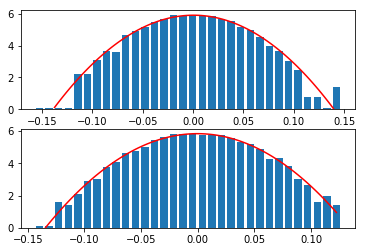

On trouve un sigma de 0.0404816125997 pour x
On trouve un sigma de 0.0392490260183 pour y


In [169]:
nbins=32
plt.subplot(2, 1, 1)
dxval,dxhist,histpolyX=GaussianHisto(dx,nbins)
pos=dxhist>0
Max,Min=dxval.max(),dxval.min()
size=(Max-Min)/dxhist.shape[0]*0.8
plt.bar(dxval[np.where(pos)],dxhist[np.where(pos)],size)
Xval=np.linspace(Min,Max,100)
HXval=histpolyX(Xval)
pos=HXval>0
plt.plot(Xval[np.where(pos)],HXval[np.where(pos)],color="red")

plt.subplot(2, 1, 2)
dyval,dyhist,histpolyY=GaussianHisto(dy,nbins)
pos=dyhist>0
Max,Min=dyval.max(),dyval.min()
size=(Max-Min)/dyhist.shape[0]*0.8
plt.bar(dyval[np.where(pos)],dyhist[np.where(pos)],size)
Yval=np.linspace(Min,Max,100)
HYval=histpolyY(Yval)
pos=HYval>0
plt.plot(Yval[np.where(pos)],HYval[np.where(pos)],color="red")
plt.show()
print("On trouve un sigma de "+str(sigma(histpolyX))+" pour x")
print("On trouve un sigma de "+str(sigma(histpolyY))+" pour y")


On repasse en version non logarithmique et on regarde l'histogramme:

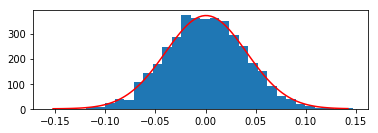

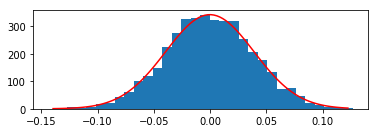

In [170]:
plt.subplot(2, 1, 1)
plt.hist(dx,nbins)
plt.plot(Xval,np.exp(histpolyX(Xval)),color="red")
plt.show()
plt.subplot(2, 1, 2)
plt.hist(dy,nbins)
plt.plot(Yval,np.exp(histpolyY(Yval)),color="red")
plt.show()

On peut aussi par exemple tracer le $msd=<X^2>$ d'une des particules:

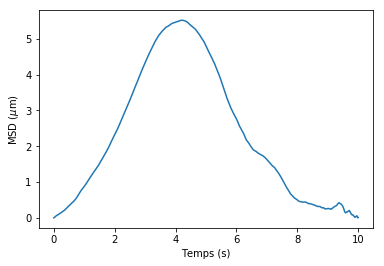

In [171]:
T,msdX=msd(x)
ok=(T>0)*(msdX>0)
T,msdX=T[np.where(ok)],msdX[np.where(ok)]
plt.plot(T,msdX)
plt.xlabel("Temps (s)")
plt.ylabel("MSD ($\mu$m)")
plt.show()

On peut aussi tracer cela en échelle log-log. En effet, la théorie prédit un accroissement linéaire de pente 1.

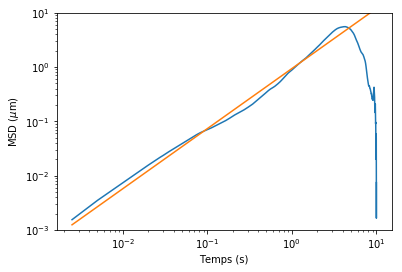

On trouve une pente de 1.10470512386


In [172]:
tot=T<6
p=np.poly1d(np.polyfit(np.log(T[np.where(tot)]),np.log(msdX[np.where(tot)]),1))
plt.loglog(T,msdX)
plt.plot(T,np.exp(p(np.log(T))))
plt.xlabel("Temps (s)")
plt.ylabel("MSD ($\mu$m)")
plt.ylim((1e-3,10))
plt.show()
print("On trouve une pente de "+str(p[1]))

In [173]:
def deltax(r):
    DeltaX=np.zeros((N,N))
    for i in range(N):
        DeltaX[i,:N-i-1]=r[i+1:]-r[:-i-1]
    return DeltaX

def truedelta(r,tau):
    return r[tau::tau]-r[:-tau:tau]

Ces fonctions calculent le déplacement effectué entre un moment $t$ et un moment $t+\tau$

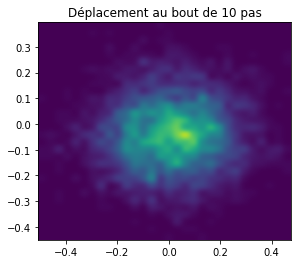

In [174]:
k=10
dkx=x[k:]-x[:-k]
dky=y[k:]-y[:-k]
h, a,b , p = plt.hist2d(dkx,dky, 30)
plt.clf()
plt.imshow(h, interpolation = "gaussian",extent=(a[0],a[-1],b[0],b[-1]))
plt.title("Déplacement au bout de "+str(k)+" pas")
plt.show()

In [177]:
def test(k,X,Y,r0=0.1,sliding=True):
    """
    Fonction qui calcule la repartition des proba de position apres k pas en utilisant une echelle spatiale de r0 
    """
    if sliding:
        dx=X[k+1:]-X[:-k-1]
        dy=Y[k+1:]-Y[:-k-1]
    else:
        dx=truedelta(X,k+1)
        dy=truedelta(Y,k+1)
    d=(dx**2+dy**2)**0.5
    n=int(d.max()/r0)
    return np.histogram(d,n)

def positionmoyenne(k,X,Y,r0=0.1,sq=1,sliding=True):
    """
    Calcule l'esperance de la distance du départ en fonction du nombre de pas
    """
    a,b=test(k,X,Y,r0,sliding)
    x=(b[:-1]+b[1:])/2
    return np.average(x**sq,weights=a)

def diffusion(sigma2):
    return sigma2/4*frequence
def viscosity(D):
    return kb*temp/(6*np.pi*a*D)

Grace a cela on peut calculer la position moyenne de la particule apres $n$ pas:

Text(0,0.5,'Distance au centre moyenne')

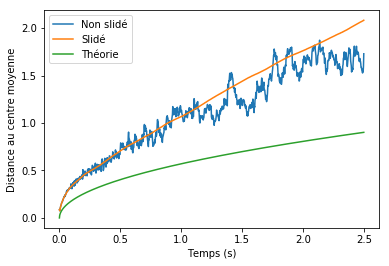

In [184]:
kmax=1000
D=diffusion(sigma(histpoly)**2+sigma(histpolyX)**2)
Xmoy=np.zeros(kmax)
for k in range(kmax):
    Xmoy[k]=positionmoyenne(k,x,y)
Xmoyn=np.zeros(kmax)
for k in range(kmax):
    Xmoyn[k]=positionmoyenne(k,x,y,sliding=False)
plt.plot(t[:k+1],Xmoyn)
plt.plot(t[:k+1],Xmoy)
plt.plot(t[:k+1],np.sqrt(D*t[:k+1]))
plt.legend(["Non slidé","Slidé","Théorie"])
plt.xlabel("Temps (s)")
plt.ylabel("Distance au centre moyenne")

Faisons juste une petite verification que l'algo de detection est honette

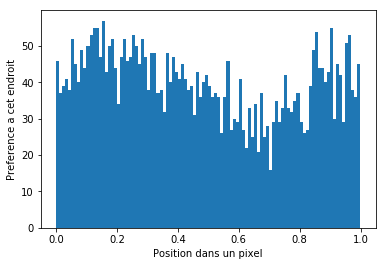

In [185]:
plt.hist(x-np.floor(x),100)
plt.xlabel("Position dans un pixel")
plt.ylabel("Preference a cet endroit")
plt.show()

On peut au fait recoller plusieurs traj pour avoir plus de stat meme si ca n'apporte pas plus d'info

In [ ]:
def concatenate(ilist=np.arange(Nbobjets)+1):
    X=[0]
    Y=[0]
    N=0
    for i in ilist:
        a=take(i)
        if a[-1]>longueurminimale:
            x1,y1,t,n=a
            X+=list(x1-x1[0]+X[-1])[1:]
            Y+=list(y1-y1[0]+Y[-1])[1:]
            N+=n
    T=np.arange(N)/frequence
    return np.array(X),np.array(Y),T,N

def distmoy(i,kmax=1000):
    x1,y1,T,N=take(i)
    D=[]
    for i in range(kmax):
        D+=[positionmoyenne(i,x1,y1,sq=2)]
    D1=np.array(D)
    a,D2=msd((x1**2+y1**2)**0.5)
    plt.plot(D1**2)
    plt.plot(D2**2)